#Setup

Import common packages

In [1]:
import argparse, datetime
from functools import reduce
import glob
import itertools as it
from multiprocessing import cpu_count, Pool
print(cpu_count())

import networkx as nx
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import random, re, shutil
from scipy.stats import hmean
import sklearn.metrics
from sklearn.metrics import auc, average_precision_score, precision_recall_curve
import seaborn as sns
import subprocess as sp
import sys
import tempfile as tf
import time
from tqdm import tqdm as progressMonitor

8


Enable Google Colab, mount drives, and load/define proprietary modules

In [2]:
%%capture
from google.colab import drive, files, output
drive.mount('/content/drive', force_remount=True)
!rm -r sample_data/

In [3]:
#useful to keep track of sys vars so as to better monitor space remaining
sysVars = list(globals().keys())

Define directories and principal object paths

In [4]:
rootDir = '/content/drive/MyDrive/'
workDir = rootDir + 'elcfs_protein_complex_modeling/' #phase2 directory
workDir_elcfs = rootDir + 'proteinPairs_complexMaps/' #modeling library
workDir_ph1 = rootDir + 'Primary Research/JLMwSCBC_notebook/' #phase 1 directory
workDir_other = rootDir + 'otherStudies/'

sys.path.insert(0, rootDir)
for p in workDir, workDir_elcfs, workDir_ph1, workDir_other: sys.path.append(p)

In [5]:
#from util import modelEvaluating
from utils import operations, reference, alertMe
pushoverKey_user = 'uith8rmy2npjj1oqpjwcanow3un984'
pushoverAPI = 'aw4v3424kaznrw598r6qge9icddwg7'

In [6]:
setupDir = workDir + 'setup/'
refDir = workDir + 'srcData/'
ph1Model_perfDir = workDir_ph1 + 'modelPerformance/'

#Helper functions

In [7]:
def sortReleases(l):
  l.sort(reverse=True, key=lambda d: datetime.datetime.strptime(
    '-'.join(d.split('_')[-1].split('.')[:3]), "%d-%m-%Y"))

  lpData = {}
  for d in l:
    k = '-'.join(d.split('_')[-1].split('.')[:3])
    print(d)

    try:
      lpData[k] = pd.read_csv(d, sep=None, engine='python')

    except:
      with open(d, 'r') as f:
        lpData[k] = pd.DataFrame([line.split(';') for line in f])

      lpData[k].columns = lpData[k].loc[0, :]
      lpData[k] = lpData[k].drop(0, axis=0)
    lpData[k].columns = [col.lower() for col in lpData[k].columns.to_list()]

  return lpData

In [8]:
def getEntries(kv):

  keyword = 'entrez'
  keywordCol = \
    {k: ''.join([col for col in df.columns.to_list() if keyword in col])
    for k, df in kv.items()}

  #keep only human entries
  kvProcessed = \
    {k: df.loc[df.organism=='Human', keywordCol[k]].replace('None', '')
    for k, df in kv.items()}

  return kvProcessed

In [9]:
def findPunctuation(kv, byEntry=False):

  charPunc = ['.', ',', ';', '|', ' ', '(', ')']
  if not byEntry:
    for p in charPunc:
      puncPresent_kv = \
        {k: any([p in l for l in df.to_list()]) for k, df in kv.items()}
      puncPresent = any([s for s in puncPresent_kv.values()])
      if puncPresent:
        print('{0} present: {1}'.format(p, puncPresent))

  else:
    puncPresent_kv = \
      {k: [[p] for p in charPunc if any([p in l for l in df.to_list()])]
      for k, df in kv.items()}

    for k, punctuation in puncPresent_kv.items():
      print('{0}: {1}'.format(k, punctuation))

In [10]:
def replacePunctuation(kv, puncDiscard, puncReplace):

  kvProcessed = {}
  for k, df in kv.items():
    for p in puncDiscard:
      df = df.replace(p, puncReplace, regex=True)
    kvProcessed[k] = df

  return kvProcessed

In [11]:
def extractCplx(kv, sep=';'):

  kvProcessed = \
      {k: [list(filter(lambda s: s.strip(), l.split(sep))) for l in df.to_list()]
       for k, df in kv.items()}

  return {k: set([frozenset(c) for c in v if c]) for k, v in kvProcessed.items()}

In [12]:
def getProts_all(kv):
  return {k: set().union(*list(v)) for k, v in kv.items()}

In [13]:
def writeAssembly(cplxs, assemblyName, oneEntry=False):
  filename = './{0}.txt'.format(assemblyName)
  with open(filename, 'w') as f:
    for l in cplxs:
      if not oneEntry:
        f.write(' '.join(l) + '\n')
      else:
        f.write(l + '\n')

  print('done')

#Alert tool

In [ ]:
#put this block after any cell expected to take a long time
cmdReport = alertMe.statusCheck(pushoverAPI, pushoverKey_user)
cmdReport.finishPush()

#Import additional class specific modules

In [ ]:
import numpy.random as rand
import pandas as pd
import pickle as p
import bisect
import scipy.misc as misc
import scipy.special as misc
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('Agg')

#Adapt hu.MAP proprietary modules (for Google Colab)

In [ ]:
def chunks(l, n):
    n = max(1, n)
    return [l[i:i + n] for i in range(0, len(l), n) if i+n< len(l)]

In [ ]:
def rand_combinations(l, n, m):
  try:
    i = int(np.ceil(1.0*m/(len(l)/n)))
    for ii in range(i):
      shuffled_l = rand.permutation(l)

      for ch in chunks(shuffled_l, n):
        yield ch
  except:
    return

In [ ]:
class Exclusion_Complexes_Exception(Exception):
  def __init__(self, value):
      self.value = value
  def __str__(self):
      return repr(self.value)

In [ ]:
class WeightedRandomGenerator(object):
  def __init__(self, weights):
    self.totals = []
    running_total = 0
    for w in weights:
      running_total += w
      self.totals.append(running_total)

  def next(self):
    rnd = random.random()*self.totals[-1]
    return bisect.bisect_right(self.totals, rnd)

  def __call__(self):
    return self.next()

In [ ]:
class ComplexComparison(object):

  def __init__(self, gold_standard=[], clusters=[],
                exclusion_complexes=[], samples=10000, pseudocount=1,
                exact=False, max_clique=None,
                remove_non_gold_standard_proteins=False,
                normalize_by_combinations=False):

    self.gold_standard = [set(x) for x in gold_standard]
    self.gold_standard_proteins = set()
    for x in gold_standard:
      self.gold_standard_proteins = self.gold_standard_proteins.union(x)
    self.clusters = [set(x) for x in clusters]

    if remove_non_gold_standard_proteins:
      self.remove_non_gold_standard_proteins()

    self.normalize_by_combinations = normalize_by_combinations
    self.exclusion_complexes = [set(x) for x in exclusion_complexes]
    self.intersection_table = None
    self.na_table = None
    self.clique_comparison_metric_results = None
    self.samples=samples
    self.pseudocount = pseudocount
    self.exact = exact
    self.max_clique = max_clique

  def remove_non_gold_standard_proteins(self,):
    filtered_clusters = []
    for c in self.clusters:
      c_filt = c.intersection(self.gold_standard_proteins)
      if len(c_filt) > 1:
        filtered_clusters.append(c_filt)

    self.clusters = filtered_clusters
    return

  def get_gold_standard(self,):
    return self.gold_standard

  def get_exclusion_complexes(self,):
    return self.exclusion_complexes

  def get_gold_standard_proteins(self,):
    return self.gold_standard_proteins

  def get_clusters(self,):
    return self.clusters

  def get_na_table(self,):
    if self.na_table is None:
      self.generate_na_table()

    return self.na_table

  def get_intersection_table(self,):
    if self.intersection_table is None:
      self.generate_intersection_table()

    return self.intersection_table

  def precision_recall_product(self, topN=None):
    pm = self.precision_measure(topN=topN)
    rm = self.recall_measure(topN=topN)
    return hmean([pm,rm])

  def precision_measure(self, topN=None):
    max_df = self.prediction_wise_max_matching_ratio_distribution(topN=topN)
    lengths = [len(x) for x in self.get_clusters()]
    sum_weighted_max = np.sum(lengths*max_df)
    precision_measure = sum_weighted_max / np.sum(lengths)
    return precision_measure

  def recall_measure(self, topN=None):
    max_df = self.max_matching_ratio_distribution(topN=topN)
    lengths = [len(x) for x in self.get_gold_standard()]
    sum_weighted_max = np.sum(lengths*max_df)
    recall_measure = sum_weighted_max / np.sum(lengths)
    return recall_measure

  def mmr_pwmmr_hmean(self, topN=None):
    mmr = self.mmr()
    pwmmr = self.pwmmr()
    return hmean([mmr, pwmmr])

  def mmr(self, topN=None):
    return self.max_matching_ratio(topN)

  def pwmmr(self, topN=None):
    return self.prediction_wise_max_matching_ratio(topN)

  def max_matching_ratio(self, topN=None):
    max_df = self.max_matching_ratio_distribution(topN=topN)
    sum_max_df = max_df.sum()
    num_of_gold_complexes = len(self.get_gold_standard())
    mmr = sum_max_df/num_of_gold_complexes
    return mmr

  def prediction_wise_max_matching_ratio(self, topN=None):
    max_df = self.prediction_wise_max_matching_ratio_distribution(topN=topN)
    sum_max_df = max_df.sum()
    num_of_clusters = len(self.get_clusters())
    pwmmr = sum_max_df/num_of_clusters
    return pwmmr

  def max_matching_ratio_distribution(self, topN=None):
    df = self.get_na_table()
    if topN != None:
      df = df.ix[:, :topN]

    max_df = df.max(axis=1)
    return max_df

  def prediction_wise_max_matching_ratio_distribution(self, topN=None):
    df = self.get_na_table()
    if topN != None:
      df = df.ix[:, :topN]

    max_df = df.max(axis=0)
    return max_df

  def sensitivity_distribution(self, topN=None):
    df = self.get_intersection_table()
    if topN != None:
      df = df.ix[:, :topN]

    sn_df = df.divide(list(map(len,self.get_gold_standard())), axis=0)
    sn_co = sn_df.max(axis=1)
    return sn_co

  def sensitivity(self, topN=None):
    sn_co = self.sensitivity_distribution(topN=topN)
    goldstd_sizes = map(len,self.get_gold_standard())
    Sn = 1.0*sum(sn_co * goldstd_sizes)/sum(goldstd_sizes)
    return Sn

  def ppv_distribution(self, topN=None):
    df = self.get_intersection_table()
    if topN != None:
      df = df.ix[:,:topN]

    ppv_df = df.divide(1.0*df.sum())
    ppv_df = ppv_df.fillna(0.0)
    PPV_cl = ppv_df.max()
    return PPV_cl

  def ppv(self, topN=None):
    df = self.get_intersection_table()
    PPV_cl = self.ppv_distribution(topN=topN)
    try:
      PPV = 1.0*sum(PPV_cl * df.sum())/sum(df.sum())
    except ZeroDivisionError:
      PPV = None
    return PPV

  def acc(self, topN=None):
    Sn = self.sensitivity(topN)
    PPV = self.ppv(topN)
    Acc = (Sn * PPV) ** (1.0/2)
    return Acc

  def clique_comparison_metric_grandf1score(self,mean_func = hmean):
    result_dict = self.clique_comparison_metric()
    f1score_list = [result_dict[x]['f1score'] for x in result_dict.keys()]
    grand_f1score = 0.0
    if 0.0 not in f1score_list:
      grand_f1score = mean_func(f1score_list)

    return grand_f1score

  def clique_comparison_metric_mean(self, weighted=False):
    result_dict = self.clique_comparison_metric()
    precision_list = [result_dict[x]['precision'] for x in result_dict.keys()]
    recall_list = [result_dict[x]['recall'] for x in result_dict.keys()]
    if weighted:
      sum_complexes = \
        sum([result_dict[x]['numOfClusters'] for x in result_dict.keys()])
      weights_list = \
        [1.0*result_dict[x]['numOfClusters']/sum_complexes
         for x in result_dict.keys()]
      precision_mean = np.average(precision_list, weights=weights_list)
      recall_mean = np.average(recall_list, weights=weights_list)
    else:
      precision_mean = np.mean(precision_list)
      recall_mean = np.mean(recall_list)
    return {'precision_mean':precision_mean,'recall_mean':recall_mean}

  def clique_comparison_metric(self, force=False):
    if self.clique_comparison_metric_results != None and not force:
      return self.clique_comparison_metric_results

    clusters = \
      [clust & self.get_gold_standard_proteins() for clust in self.get_clusters()]
    clust_max_len = np.max(list(map(len,clusters)))
    gs_max_len = np.max(list(map(len,self.get_gold_standard())))
    return_dict = dict()
    if self.max_clique == None:
      max_len = clust_max_len
    else:
      max_len = min(self.max_clique, clust_max_len)

    cumulative_gs_tp = 0.0
    cumulative_tp = 0.0
    cumulative_fn = 0.0
    cumulative_fp = 0.0
    for size in range(2, max_len+1):
      zero_w_pseudocount = \
        1.0*self.pseudocount / (self.samples + 2*self.pseudocount)

      if (size > 4) and \
        (return_dict[size-1]['precision'] == zero_w_pseudocount) and \
          (return_dict[size-1]['recall'] == zero_w_pseudocount) and \
          (return_dict[size-2]['precision'] == zero_w_pseudocount) and \
            (return_dict[size-2]['recall'] == zero_w_pseudocount):

            return_dict[size] = \
              {'precision': zero_w_pseudocount, 'f1score': zero_w_pseudocount,
                'recall': zero_w_pseudocount,
                'cumulative_recall': zero_w_pseudocount,
                'cumulative_precision': zero_w_pseudocount, 'numOfClusters': 0}
            continue

      if gs_max_len < size:
        return_dict[size] = \
          {'precision': zero_w_pseudocount,'f1score': zero_w_pseudocount,
            'recall': zero_w_pseudocount,
            'cumulative_recall': zero_w_pseudocount,
            'cumulative_precision': zero_w_pseudocount, 'numOfClusters': 0}
        continue

      if self.exact:
        result_dict = self.clique_comparison_exact(size)
      else:
        result_dict = self.clique_comparison(size)

      cumulative_gs_tp += result_dict['gs_tp']
      cumulative_tp += result_dict['tp']
      cumulative_fp += result_dict['fp']
      cumulative_fn += result_dict['fn']
      cumulative_recall = \
        1.0*cumulative_gs_tp / (cumulative_gs_tp + cumulative_fn)
      cumulative_precision = \
        1.0*cumulative_tp / (cumulative_tp + cumulative_fp)
      recall = \
        1.0*result_dict['gs_tp'] / (result_dict['gs_tp'] + result_dict['fn'])
      precision = \
        1.0*result_dict['tp'] / (result_dict['tp'] + result_dict['fp'])
      f1score = 0.0
      if precision != 0.0 and recall != 0.0:
        f1score = hmean([recall, precision])

      return_dict[size] = \
        {'precision': precision, 'recall':recall, 'f1score': f1score,
          'cumulative_recall': cumulative_recall,
          'cumulative_precision': cumulative_precision,
          'numOfClusters': result_dict['numOfClusters']}

    self.clique_comparison_metric_results = return_dict
    return return_dict

  def clique_comparison_exact(self,clique_size):
    true_positives = self.pseudocount
    gs_true_positives = self.pseudocount
    false_positives = self.pseudocount
    false_negatives = self.pseudocount

    if len(self.get_exclusion_complexes()) > 0:
      raise Exclusion_Complexes_Exception(
          "ERROR: EXCLUSION COMPLEX functionality is not implemented for ' + \
          'exact method (def clique_comparison_exact), ' + \
          'use estimated (def clique_comparison)")

    clusters = \
      [clust & self.get_gold_standard_proteins()
      for clust in self.get_clusters()
      if len(clust & self.get_gold_standard_proteins()) >= clique_size]

    for clust in clusters:
      is_positive_list = \
        [np.max(list(map(set(group).issubset,self.get_gold_standard())))
        for group in it.combinations(clust, clique_size)]
      tp_curr = sum(is_positive_list)
      if self.normalize_by_combinations:
        tp_curr = tp_curr * (1.0*len(clust)/misc.comb(len(clust),clique_size))

      true_positives += tp_curr
      fp_curr = len(is_positive_list) - tp_curr
      if self.normalize_by_combinations:
        fp_curr = fp_curr * (1.0*len(clust)/misc.comb(len(clust),clique_size))

      false_positives += fp_curr

    for gs_clust in self.get_gold_standard():
      is_positive_list = \
        [np.max(list(map(set(gs_group).issubset,clusters)))
        for gs_group in it.combinations(gs_clust, clique_size)]

      gs_tp_curr = sum(is_positive_list)
      if self.normalize_by_combinations:
        gs_tp_curr = \
          gs_tp_curr * (1.0*len(gs_clust)/misc.comb(len(gs_clust),clique_size))

      gs_true_positives += gs_tp_curr
      fn_curr = sum(np.logical_not(is_positive_list))
      if self.normalize_by_combinations:
        fn_curr = \
          fn_curr * (1.0*len(gs_clust)/misc.comb(len(gs_clust),clique_size))

      false_negatives += fn_curr

    return_dict = dict()
    return_dict['tp'] = true_positives
    return_dict['gs_tp'] = gs_true_positives
    return_dict['fp'] = false_positives
    return_dict['fn'] = false_negatives
    return_dict['numOfClusters'] = len(clusters)
    return return_dict

  def clique_comparison(self, clique_size):
    true_positives = self.pseudocount
    gs_true_positives = self.pseudocount
    false_positives = self.pseudocount
    false_negatives = self.pseudocount
    clusters = \
      [clust & self.get_gold_standard_proteins()
      for clust in self.get_clusters()
      if len(clust & self.get_gold_standard_proteins()) >= clique_size]
    weights_array = \
      [misc.comb(len(clust & self.get_gold_standard_proteins()), clique_size)
      for clust in clusters ]
    wrg = WeightedRandomGenerator( weights_array )
    random_cliques = set()
    random_clique_weights = dict()
    for s in range(self.samples):
      clust = clusters[wrg()]
      clust_intersection = clust & self.get_gold_standard_proteins()
      if len(clust_intersection) <= 0:
        continue

      shuffled_l = rand.permutation(list(clust_intersection))
      random_cliques.add(frozenset(shuffled_l[:clique_size]))
      random_clique_weights[frozenset(shuffled_l[:clique_size])] = \
        (1.0*len(clust)/misc.comb(len(clust),clique_size))

    for random_clique in random_cliques:
      if np.max(list(map(random_clique.issubset,self.get_gold_standard()))):
        if self.normalize_by_combinations:
          true_positives += 1 * random_clique_weights[random_clique]
        else:
          true_positives += 1
      else:
        if (len(self.get_exclusion_complexes()) > 0) and \
          (np.max(list(map(random_clique.issubset,
                           self.get_exclusion_complexes())))):
          continue

        else:
          if self.normalize_by_combinations:
            false_positives += 1 * random_clique_weights[random_clique]
          else:
            false_positives += 1

    gs_clusters = \
      [gs_clust for gs_clust in self.get_gold_standard()
      if len(gs_clust) >= clique_size]

    gs_wrg = \
      WeightedRandomGenerator([misc.comb(len(gs_clust), clique_size)
      for gs_clust in gs_clusters ])

    random_gs_cliques = set()
    random_gs_clique_weights = dict()
    for s in range(self.samples):
      gs_clust = gs_clusters[gs_wrg()]
      shuffled_l = rand.permutation(list(gs_clust))
      random_gs_cliques.add(frozenset(shuffled_l[:clique_size]))
      random_gs_clique_weights[frozenset(shuffled_l[:clique_size])] = \
        (1.0*len(gs_clust)/misc.comb(len(gs_clust),clique_size))

    for random_clique in random_gs_cliques:
      if np.max(list(map(random_clique.issubset, clusters))):
        if self.normalize_by_combinations:
          gs_true_positives += 1 * random_gs_clique_weights[random_clique]
        else:
          gs_true_positives += 1
      else:
        if self.normalize_by_combinations:
          false_negatives += 1 * random_gs_clique_weights[random_clique]
        else:
          false_negatives += 1

    return_dict = dict()
    return_dict['tp'] = true_positives
    return_dict['gs_tp'] = gs_true_positives
    return_dict['fp'] = false_positives
    return_dict['fn'] = false_negatives
    return_dict['numOfClusters'] = len(clusters)
    return return_dict

  def generate_intersection_table(self,):
    rows_list = []
    for cc in self.get_gold_standard():
      d = dict()
      for i, clst in enumerate(self.get_clusters()):
        d[i] = 1.0*len(set.intersection(set(clst),set(cc)))
        rows_list.append(d)
    self.intersection_table = pd.DataFrame(rows_list)

  def generate_na_table(self,):
    rows_list = []
    for cc in self.get_gold_standard():
      d = dict()
      for i, clst in enumerate(self.get_clusters()):
        numerator = (1.0*len(set.intersection(set(clst),set(cc))))**2
        denominator = 1.0 * (len(set(clst)) * len(set(cc)))

        d[i] = numerator / denominator
        rows_list.append(d)
    self.na_table = pd.DataFrame(rows_list)

#Main

In [ ]:
def evalClusters(args):
  parser = argparse.ArgumentParser()
  parser.add_argument('--cluster_predictions',
                      action='store', dest='cluster_filename',
                      required=True)
  parser.add_argument('--gold_standard',
                      action='store', dest='gold_standard_filename',
                      required=True)
  parser.add_argument('--plot_filename',
                      action='store', dest='plot_filename',
                      required=False, default=None)
  parser.add_argument('--remove_non_gold_standard_proteins',
                      action='store_true',
                      dest='remove_non_gold_standard_proteins',
                      required=False, default=True)
  parser.add_argument('--normalize_by_combinations',
                      action='store_true', dest='normalize_by_combinations',
                      required=False, default=True)
  parser.add_argument('--excluded_complexes',
                      action='store', dest='excluded_complexes',
                      required=False, default=None)
  parser.add_argument('--pseudocount',
                      action='store', type=float, dest='pseudocount',
                      required=False, default=0.00001)
  exp = parser.parse_args(args)

  gold_standard_complexes = []
  with open(exp.gold_standard_filename, 'rb') as gold_file:
    for line in gold_file.readlines():
      gold_standard_complexes.append(line.split())
  print('Total gold standard complexes: {0}'.format(len(gold_standard_complexes)))

  predicted_clusters = []
  with open(exp.cluster_filename, 'rb') as clpred_f:
    for line in clpred_f.readlines():
      predicted_clusters.append(line.split())
  print('Total predicted clusters: {0}'.format(len(predicted_clusters)))

  excluded_complexes = []
  if exp.excluded_complexes != None:
    with open(exp.excluded_complexes, 'rb') as exclude_file:
      for line in exclude_file.readlines():
        excluded_complexes.append(line.split())
  print('Total excluded complexes: {0}'.format(len(excluded_complexes)))

  cplx_compare = ComplexComparison(
      gold_standard_complexes, predicted_clusters,
      remove_non_gold_standard_proteins=exp.remove_non_gold_standard_proteins,
      exclusion_complexes=excluded_complexes,
      normalize_by_combinations=exp.normalize_by_combinations,
      pseudocount=exp.pseudocount)

  ccmm = cplx_compare.clique_comparison_metric_mean()
  clique_pr_mean = ccmm['precision_mean']
  clique_re_mean = ccmm['recall_mean']

  clique_f1grand = \
    cplx_compare.clique_comparison_metric_grandf1score(mean_func=np.mean)

  wccmm = cplx_compare.clique_comparison_metric_mean(weighted=True)
  clique_weighted_pr_mean = wccmm['precision_mean']
  clique_weighted_re_mean = wccmm['recall_mean']
  clique_weighted_hmean = hmean([wccmm['precision_mean'], wccmm['recall_mean']])

  Measure = \
    ['Clique Precision Mean', 'Recall Mean', 'F-Grand K-Clique',
    'Clique Weighted Precision Mean', 'Weighted Recall Mean',
    'Clique Weighted hmean (F-weighted K-Clique)']
  Value = \
    [clique_pr_mean, clique_re_mean,
    clique_f1grand, clique_weighted_pr_mean, clique_weighted_re_mean,
    clique_weighted_hmean]

  evalMeasures = dict(zip(Measure, Value))
  evalMeasures_df = \
    pd.DataFrame(evalMeasures.items(), columns=['Measure', 'Value'])

  return evalMeasures_df

**ComplexComparison required arguments**

*   cluster_predictions
*   gold_standard

In [ ]:
'''
args = \
  ['--cluster_prediction', 'path/to/predictionsFile',
   '--gold_standard', 'path/to/referenceFile']
evalDF = evalClusters(args)
evalDF
'''

"\nargs =   ['--cluster_prediction', 'path/to/predictionsFile',\n   '--gold_standard', 'path/to/referenceFile']\nevalDF = evalClusters(args)\nevalDF\n"

#hu.MAP 1.0 vs Test Clusters

**Calculate Metrics**

In [ ]:
args = \
  ['--cluster_prediction', '/content/clusters.txt',
   '--gold_standard', '/content/test_complexes.txt']
evalDF = evalClusters(args)
evalDF

Total gold standard complexes: 264
Total predicted clusters: 4659
Total excluded complexes: 0


,Measure,Value
0,Clique Precision Mean,0.576934
1,Recall Mean,0.394622
2,F-Grand K-Clique,0.452176
3,Clique Weighted Precision Mean,0.571110
4,Weighted Recall Mean,0.234311
5,Clique Weighted hmean (F-weighted K-Clique),0.332292


#Compare CORUM releases

*Load data (CORUM assemblies--all releases)*

In [ ]:
corumReleases_dir = refDir + 'CORUM/*Complexes*'
corumRelease_files = glob.glob(corumReleases_dir)
corumReleases = sortReleases(corumRelease_files)
corumReleases_entries = getEntries(corumReleases)

puncDiscard = [',', '\(', '\)', 'None']
corumReleases_singlePunc_entries = \
  replacePunctuation(corumReleases_entries, puncDiscard, ';')
corumReleases_singlePunc_entriesExtract = \
  extractCplx(corumReleases_singlePunc_entries)

/content/drive/MyDrive/elcfs_protein_complex_modeling/srcData/CORUM/humanComplexes_28.11.2022.txt
/content/drive/MyDrive/elcfs_protein_complex_modeling/srcData/CORUM/humanComplexes_09.09.2022.txt
/content/drive/MyDrive/elcfs_protein_complex_modeling/srcData/CORUM/coreComplexes_03.09.2018.txt
/content/drive/MyDrive/elcfs_protein_complex_modeling/srcData/CORUM/coreComplexes_01.07.2018.txt
/content/drive/MyDrive/elcfs_protein_complex_modeling/srcData/CORUM/coreComplexes_02.07.2017.txt
/content/drive/MyDrive/elcfs_protein_complex_modeling/srcData/CORUM/coreComplexes_03.05.2017.txt
/content/drive/MyDrive/elcfs_protein_complex_modeling/srcData/CORUM/coreComplexes_15.12.2016.txt
/content/drive/MyDrive/elcfs_protein_complex_modeling/srcData/CORUM/allComplexesCore_17.02.2012.csv


*Save assemblies to local disk (COLAB) for input to ComplexComparison*

**Calculate Metrics**

In [ ]:
assembly28112022 = corumReleases_singlePunc_entriesExtract['28-11-2022']
assembly09092022 = corumReleases_singlePunc_entriesExtract['09-09-2022']

assembly28112022 = [list(c) for c in assembly28112022]
assembly09092022 = [list(c) for c in assembly09092022]

writeAssembly(assembly28112022, 'corumRelease_28-11-2022')
writeAssembly(assembly09092022, 'corumRelease_09-09-2022')

done
done


In [ ]:
args = \
  ['--cluster_prediction', '/content/corumRelease_28-11-2022.txt',
   '--gold_standard', '/content/corumRelease_09-09-2022.txt']
evalDF = evalClusters(args)
evalDF

Total gold standard complexes: 3556
Total predicted clusters: 3605
Total excluded complexes: 0


,Measure,Value
0,Clique Precision Mean,0.525182
1,Recall Mean,0.524985
2,F-Grand K-Clique,0.525082
3,Clique Weighted Precision Mean,0.799996
4,Weighted Recall Mean,0.797887
5,Clique Weighted hmean (F-weighted K-Clique),0.798940


**Calculate Metrics**

In [ ]:
assemblies = \
  {'assembly'+k: [list(c) for c in v]
   for k, v in corumReleases_singlePunc_entriesExtract.items()}

for k, v in assemblies.items(): writeAssembly(v, k)

done
done
done
done
done
done
done
done


In [ ]:
corumRelease_pairs = \
  [['--cluster_prediction', './{0}.txt'.format(list(pair)[0]),
    '--gold_standard', './{0}.txt'.format(list(pair)[1])]
  for pair in list(it.combinations(assemblies.keys(), 2))]

In [ ]:
numWorkers = cpu_count() - 1
with Pool(numWorkers) as pool:
  corumRelease_pairComparisons = \
    list(progressMonitor(pool.imap(evalClusters, corumRelease_pairs),
                         total=len(corumRelease_pairs)))

  0%|          | 0/28 [00:00<?, ?it/s]

Total gold standard complexes: 1771Total gold standard complexes: 2400Total gold standard complexes: 1339
Total gold standard complexes: 1339Total gold standard complexes: 2400Total gold standard complexes: 1737Total gold standard complexes: 2329
Total gold standard complexes: 1392Total gold standard complexes: 1737Total gold standard complexes: 1771Total gold standard complexes: 1771
Total gold standard complexes: 2329Total gold standard complexes: 1392Total gold standard complexes: 3556Total gold standard complexes: 1339Total gold standard complexes: 2329


Total gold standard complexes: 1339

Total gold standard complexes: 1771


Total gold standard complexes: 1737


Total gold standard complexes: 1392
Total gold standard complexes: 1392Total gold standard complexes: 1737Total gold standard complexes: 1339
Total gold standard complexes: 1392Total gold standard complexes: 1339Total gold standard complexes: 1339


Total predicted clusters: 3605




Total predicted clusters: 3605Total 

100%|██████████| 28/28 [16:19<00:00, 34.98s/it]  


In [ ]:
corumRelease_f1scoreDrift = \
  dict(zip(
      [frozenset(pair) for pair in list(it.combinations(assemblies.keys(), 2))],
      corumRelease_pairComparisons))

In [ ]:
shortcutData_filesDir = workDir + 'google_colab_notebooks/Notebook QC/'
pickle.dump(corumRelease_f1scoreDrift,
            open(shortcutData_filesDir + 'corumRelease_f1scoreDrift.pkl', 'wb'))

In [ ]:
corumRelease_f1scoreDrift_df = \
  pd.DataFrame(
      {'CORUM Releases':
       [pair for pair in corumRelease_f1scoreDrift.keys()],
       'k-Clique weighted-F1':
        [df.loc[df.Measure=='Clique Weighted hmean (F-weighted K-Clique)',
                'Value'].values[0]
         for df in corumRelease_f1scoreDrift.values()]})

In [ ]:
corumRelease_f1scoreDrift_df.sort_values(by='k-Clique weighted-F1').head()

,CORUM Releases,k-Clique weighted-F1
11,"(assembly09-09-2022, assembly15-12-2016)",0.719202
6,"(assembly28-11-2022, assembly17-02-2012)",0.772083
12,"(assembly09-09-2022, assembly17-02-2012)",0.773555
5,"(assembly28-11-2022, assembly15-12-2016)",0.781513
10,"(assembly09-09-2022, assembly03-05-2017)",0.802535


In [ ]:
corumRelease_f1scoreDrift_df.sort_values(by='k-Clique weighted-F1',
                                         ascending=False).head()

,CORUM Releases,k-Clique weighted-F1
0,"(assembly09-09-2022, assembly28-11-2022)",0.885216
13,"(assembly03-09-2018, assembly01-07-2018)",0.864840
19,"(assembly03-05-2017, assembly01-07-2018)",0.852822
22,"(assembly02-07-2017, assembly03-05-2017)",0.852450
14,"(assembly02-07-2017, assembly03-09-2018)",0.847910


#STRING(v12) <-> CORUM(11.28.2022) <-> hu.MAP 2.0

*Load STRING complexes by using ELCFS pipeline reference module cmpStudies*

In [ ]:
humap1Dir = refDir + 'huMAP1/'
humap2Dir = refDir + 'huMAP2/'
bcb19Dir_LM = refDir + 'Lugo-Martinez2019/'
stringdbDir = refDir + 'STRING/'
geneidDir = refDir + 'ftp.ncbi.nih.gov-geneData_global/'
cmpStudies = reference.cmpStudies_props(
    humap1Dir, humap2Dir, bcb19Dir_LM, stringdbDir, geneidDir)
cmpStudies.getSTRING()

193470
20644
STRING pair predictions dims: (13715404, 17)
# string IDs: 19622
# string ID aliases: 19699
# stringID-mapped geneids: 19254
# geneID-mapped stringIDs: 19242
GeneID-mapped STRING pair predictions dims: (13538618, 17)
GeneID-mapped STRING protein1 expansion dims: (13757586, 19)
GeneID-mapped STRING protein2 expansion dims: (13982180, 19)
pooling...


100%|██████████| 13982180/13982180 [10:29<00:00, 22219.68it/s]


# geneID-mapped STRING proteins: 19232
STRING geneID-mapped pair predictions aggregated dims: 6881445
# completely, geneID-mapped STRING protein complexes: 3870


100%|██████████| 3870/3870 [00:02<00:00, 1303.89it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Avoid wasting time by reloading time-expensive computations

In [ ]:
shortcutData_filesDir = workDir + 'google_colab_notebooks/Notebook QC/'
pickle.dump(cmpStudies,
            open(shortcutData_filesDir + 'cmpStudies_stringSup.pkl', 'wb'))

In [ ]:
stringCplxs_v12 = [list(c) for c in cmpStudies.stringCplxs]
writeAssembly(stringCplxs_v12, 'stringCplxs_v12')

done


##CORUM(11.28.22)==ref

**Calculate Metrics**

In [ ]:
args = \
  ['--cluster_prediction', '/content/stringCplxs_v12.txt',
   '--gold_standard', '/content/corumRelease_28-11-2022.txt']
evalDF = evalClusters(args)
evalDF

Total gold standard complexes: 3605
Total predicted clusters: 3870
Total excluded complexes: 0


,Measure,Value
0,Clique Precision Mean,0.410958
1,Recall Mean,0.403087
2,F-Grand K-Clique,0.401232
3,Clique Weighted Precision Mean,0.443422
4,Weighted Recall Mean,0.500300
5,Clique Weighted hmean (F-weighted K-Clique),0.470147


##STRING(v12)==ref

**Calculate Metrics**

In [ ]:
args = \
  ['--cluster_prediction', '/content/corumRelease_28-11-2022.txt',
   '--gold_standard', '/content/stringCplxs_v12.txt']
evalDF = evalClusters(args)
evalDF

Total gold standard complexes: 3870
Total predicted clusters: 3605
Total excluded complexes: 0


,Measure,Value
0,Clique Precision Mean,0.484499
1,Recall Mean,0.493709
2,F-Grand K-Clique,0.480599
3,Clique Weighted Precision Mean,0.497064
4,Weighted Recall Mean,0.285602
5,Clique Weighted hmean (F-weighted K-Clique),0.362766


*Load hu.MAP 2.0 complex predictions*

In [ ]:
humap2Cplxs = pd.read_csv(humap2Dir + 'humap2_complexes_20200809.txt', sep=',')

In [ ]:
humap2Cplxs_uniprot = \
  [frozenset(l.split(' ')) for l in humap2Cplxs.Uniprot_ACCs.to_list()]
humap2Cplxs_subunitsUniprot = \
  set().union(*humap2Cplxs_uniprot)
print(len(humap2Cplxs_subunitsUniprot))

9963


In [ ]:
writeAssembly(humap2Cplxs_subunitsUniprot, 'humap2Cplxs_subunitIDs', oneEntry=True)

done


In [ ]:
#uploaded file to uniprotid conversion site and downloaded results locally
humap2Cplxs_subunitsUniprot_geneidCon = \
  pd.read_csv('/content/humap2Cplxs_subunitIDs->GeneID.tsv', sep='\t')
humap2Cplxs_subunitsUniprot_geneidCon.To = \
  humap2Cplxs_subunitsUniprot_geneidCon.To.astype('str')
humap2Cplxs_subunitsUniprot_geneidCon.rename(
    columns={'From': 'Uniprot_ACCs', 'To': 'GeneID'}, inplace=True)
humap2Cplxs_subunitsUniprot_geneidCon = \
  humap2Cplxs_subunitsUniprot_geneidCon.groupby(
      ['Uniprot_ACCs'], as_index=False).agg(' '.join)
humap2Cplxs_subunitsUniprot_geneidCon = \
  dict(zip(humap2Cplxs_subunitsUniprot_geneidCon.Uniprot_ACCs,
           humap2Cplxs_subunitsUniprot_geneidCon.GeneID))

In [ ]:
humap2Cplxs_uniprotGeneid = \
  [frozenset(' '.join(
      [humap2Cplxs_subunitsUniprot_geneidCon[p]
       for p in l.split(' ') if p in humap2Cplxs_subunitsUniprot_geneidCon]).split(' '))
  for l in humap2Cplxs.Uniprot_ACCs.to_list()]

humap2Cplxs.insert(
    3, 'Uniprot_ACCs->GeneID',
    [' '.join(c) for c in humap2Cplxs_uniprotGeneid])

In [ ]:
humap2Cplxs.to_csv(humap2Dir + 'humap2_complexes_20200809_addedGeneid.txt', sep=',')

In [ ]:
writeAssembly(humap2Cplxs_uniprotGeneid, 'humap2Cplxs_geneids')

done


##STRING(v12)==ref

**Calculate Metrics**

In [ ]:
args = \
  ['--cluster_prediction', '/content/humap2Cplxs_geneids.txt',
   '--gold_standard', '/content/stringCplxs_v12.txt']
evalDF = evalClusters(args)
evalDF

Total gold standard complexes: 3870
Total predicted clusters: 6965
Total excluded complexes: 0


,Measure,Value
0,Clique Precision Mean,0.458246
1,Recall Mean,0.488826
2,F-Grand K-Clique,0.459109
3,Clique Weighted Precision Mean,0.335198
4,Weighted Recall Mean,0.296815
5,Clique Weighted hmean (F-weighted K-Clique),0.314841


##hu.MAP 2.0==ref

**Calculate Metrics**

In [ ]:
args = \
  ['--cluster_prediction', '/content/stringCplxs_v12.txt',
   '--gold_standard', '/content/humap2Cplxs_geneids.txt']
evalDF = evalClusters(args)
evalDF

Total gold standard complexes: 6965
Total predicted clusters: 3870
Total excluded complexes: 0


,Measure,Value
0,Clique Precision Mean,0.182041
1,Recall Mean,0.170615
2,F-Grand K-Clique,0.171702
3,Clique Weighted Precision Mean,0.433325
4,Weighted Recall Mean,0.417705
5,Clique Weighted hmean (F-weighted K-Clique),0.425372


#hu.MAP 2.0 vs. hu.MAP 2.0 Leave-Out Test Complexes set, vs CORUM (11.28.22)

##hu.MAP 2.0 Leave-Out Test Set Complexes==ref

In [ ]:
humap2Cplxs_testRef = \
  pickle.load(open('./humap2_test_complexes_geneid_20200818.pkl', 'rb'))

In [ ]:
writeAssembly(humap2Cplxs_testRef, 'humap2Cplxs_testRef')

done


**Calculate Metrics**

In [ ]:
args = \
  ['--cluster_prediction', '/content/humap2Cplxs_geneids.txt',
   '--gold_standard', '/content/humap2Cplxs_testRef.txt']
evalDF = evalClusters(args)
evalDF

Total gold standard complexes: 589
Total predicted clusters: 6965
Total excluded complexes: 0


,Measure,Value
0,Clique Precision Mean,0.634321
1,Recall Mean,0.414512
2,F-Grand K-Clique,0.474606
3,Clique Weighted Precision Mean,0.582266
4,Weighted Recall Mean,0.332877
5,Clique Weighted hmean (F-weighted K-Clique),0.423591


##CORUM(11.28.2022)==ref

**Calculate Metrics**

In [ ]:
args = \
  ['--cluster_prediction', '/content/humap2Cplxs_geneids.txt',
   '--gold_standard', '/content/corumRelease_28-11-2022.txt']
evalDF = evalClusters(args)
evalDF

Total gold standard complexes: 3605
Total predicted clusters: 6965
Total excluded complexes: 0


,Measure,Value
0,Clique Precision Mean,0.471280
1,Recall Mean,0.491987
2,F-Grand K-Clique,0.469542
3,Clique Weighted Precision Mean,0.505461
4,Weighted Recall Mean,0.373021
5,Clique Weighted hmean (F-weighted K-Clique),0.429258


#LM2019 Top 0.02% vs CORUM(11.28.2022)

In [ ]:
tempLst = []
with open('/content/lm2019_top0.02%.csv', 'r') as f:
  for l in f.readlines():
    tempLst.append([p for p in l.split(',') if all([p, p!='\n'])])
writeAssembly(tempLst, 'lm2019_top0.02%')

done


**Calculate Metrics**

In [ ]:
args = \
  ['--cluster_prediction', '/content/lm2019_top0.02%.txt',
   '--gold_standard', '/content/corumRelease_28-11-2022.txt']
evalDF = evalClusters(args)
evalDF

Total gold standard complexes: 3605
Total predicted clusters: 1351
Total excluded complexes: 0


,Measure,Value
0,Clique Precision Mean,0.645609
1,Recall Mean,0.462701
2,F-Grand K-Clique,0.510103
3,Clique Weighted Precision Mean,0.648001
4,Weighted Recall Mean,0.395496
5,Clique Weighted hmean (F-weighted K-Clique),0.491198


#hu.MAP 2.0 & CORUM 11.28.22 (by confidence)

**Calculate Metrics**

In [ ]:
Measure = \
 ['Clique Precision Mean', 'Recall Mean', 'F-Grand K-Clique',
  'Clique Weighted Precision Mean', 'Weighted Recall Mean',
  'Clique Weighted hmean (F-weighted K-Clique)']

In [ ]:
args = \
  ['--cluster_prediction', '',
   '--gold_standard', '/content/humap2_test_complexes_geneid_20200818.txt']
humap2Cluster_byConfidence_eval = \
  pd.DataFrame(Measure, columns=['Measure'])
for conf in sorted(humap2Cplxs.Confidence.unique()):
  resultsName = 'Confidence={0} Metrics'.format(conf)
  print(resultsName)

  cplxs = \
    [l.split(' ') for l in humap2Cplxs.loc[humap2Cplxs.Confidence == conf,
                                           'Uniprot_ACCs->GeneID'].to_list()]
  print(len(cplxs))

  writeAssembly(cplxs, 'cplxs')
  args[1] = './cplxs.txt'
  evalDF = evalClusters(args)
  humap2Cluster_byConfidence_eval[resultsName] = evalDF['Value'].copy()

humap2Cluster_byConfidence_eval

Confidence=1 Metrics
242
done
Total gold standard complexes: 589
Total predicted clusters: 242
Total excluded complexes: 0
Confidence=2 Metrics
1317
done
Total gold standard complexes: 589
Total predicted clusters: 1317
Total excluded complexes: 0
Confidence=3 Metrics
745
done
Total gold standard complexes: 589
Total predicted clusters: 745
Total excluded complexes: 0
Confidence=4 Metrics
2265
done
Total gold standard complexes: 589
Total predicted clusters: 2265
Total excluded complexes: 0
Confidence=5 Metrics
2396
done
Total gold standard complexes: 589
Total predicted clusters: 2396
Total excluded complexes: 0


,Measure,Confidence=1 Metrics,Confidence=2 Metrics,Confidence=3 Metrics,Confidence=4 Metrics,Confidence=5 Metrics
0,Clique Precision Mean,0.607628,0.673062,0.422337,0.677984,0.653622
1,Recall Mean,0.330315,0.366098,0.397178,0.403219,0.379633
2,F-Grand K-Clique,0.318083,0.433391,0.330855,0.474332,0.449590
3,Clique Weighted Precision Mean,0.779967,0.696467,0.647096,0.639020,0.542696
4,Weighted Recall Mean,0.123186,0.180738,0.200642,0.272910,0.221462
5,Clique Weighted hmean (F-weighted K-Clique),0.212768,0.286998,0.306308,0.382475,0.314559


In [ ]:
humap2Cluster_byConfidence_eval.set_index('Measure', inplace=True)

In [ ]:
humap2Cluster_byConfidence_eval

,Confidence=1 Metrics,Confidence=2 Metrics,Confidence=3 Metrics,Confidence=4 Metrics,Confidence=5 Metrics
Measure,,,,,
Clique Precision Mean,0.607628,0.673062,0.422337,0.677984,0.653622
Recall Mean,0.330315,0.366098,0.397178,0.403219,0.379633
F-Grand K-Clique,0.318083,0.433391,0.330855,0.474332,0.449590
Clique Weighted Precision Mean,0.779967,0.696467,0.647096,0.639020,0.542696
Weighted Recall Mean,0.123186,0.180738,0.200642,0.272910,0.221462
Clique Weighted hmean (F-weighted K-Clique),0.212768,0.286998,0.306308,0.382475,0.314559


In [ ]:
data = pd.read_excel('./data.xlsx', sheet_name='Sheet2')

In [ ]:
data

,Weighted Recall Mean,Clique Weighted Precision Mean,Size
0,0.123186,0.779967,242
1,0.180738,0.696467,1317
2,0.200642,0.647096,745
3,0.272910,0.639020,2265
4,0.221462,0.542696,2396


<Axes: xlabel='Weighted Recall Mean', ylabel='Clique Weighted Precision Mean'>

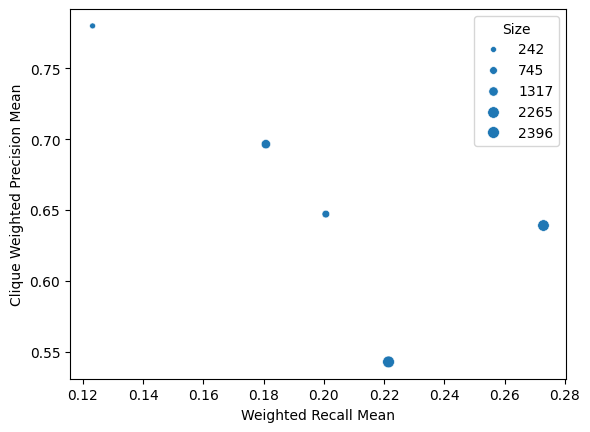

In [ ]:
sns.scatterplot(data=data, x='Weighted Recall Mean', y='Clique Weighted Precision Mean', size='Size')

In [ ]:
sns.scatterplot(x=humap2Cluster_byConfidence_eval.loc['Weighted Recall Mean', :],
                y=humap2Cluster_byConfidence_eval.loc['Clique Weighted Precision Mean', :])

<Axes: xlabel='Weighted Recall Mean', ylabel='Clique Weighted Precision Mean'>